In [1]:
import os, json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support


2025-09-27 00:21:07.464366: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-27 00:21:07.465366: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-27 00:21:07.485017: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-27 00:21:07.485784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-27 00:21:07.779372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
def load_labels(model_dir):
    with open(os.path.join(model_dir, "label_map.json"), "r", encoding="utf-8") as f:
        m = json.load(f)
    id2label = {int(k): v for k, v in m["id2label"].items()}
    return id2label

def try_load_keras(model_dir):
    return tf.keras.models.load_model(model_dir, compile=False)

def try_load_savedmodel(model_dir):
    sm = tf.saved_model.load(model_dir)
    infer = sm.signatures.get("serving_default", None)
    if infer is None:
        raise ValueError("No 'serving_default' signature in SavedModel.")
    return infer


In [3]:
def load_labels(model_dir):
    with open(os.path.join(model_dir, "label_map.json"), "r", encoding="utf-8") as f:
        m = json.load(f)
    id2label = {int(k): v for k, v in m["id2label"].items()}
    return id2label

def try_load_keras(model_dir):
    return tf.keras.models.load_model(model_dir, compile=False)

def try_load_savedmodel(model_dir):
    sm = tf.saved_model.load(model_dir)
    infer = sm.signatures.get("serving_default", None)
    if infer is None:
        raise ValueError("No 'serving_default' signature in SavedModel.")
    return infer


In [4]:
def predict_texts(model_or_fn, id2label, texts, batch_size=32, is_keras=True):
    if is_keras:
        ds = tf.data.Dataset.from_tensor_slices(texts).batch(batch_size)
        probs = model_or_fn.predict(ds)
    else:
        try:
            out = model_or_fn(text=tf.constant(texts, dtype=tf.string)[:, None])
        except Exception:
            out = model_or_fn(text=tf.constant(texts, dtype=tf.string))
        probs = next(iter(out.values())).numpy()

    idx = probs.argmax(axis=1)
    conf = probs[np.arange(len(texts)), idx]
    labels = [id2label[int(i)] for i in idx]
    return labels, conf, probs


In [5]:
def predict_texts(model_or_fn, id2label, texts, batch_size=32, is_keras=True):
    if is_keras:
        ds = tf.data.Dataset.from_tensor_slices(texts).batch(batch_size)
        probs = model_or_fn.predict(ds)
    else:
        try:
            out = model_or_fn(text=tf.constant(texts, dtype=tf.string)[:, None])
        except Exception:
            out = model_or_fn(text=tf.constant(texts, dtype=tf.string))
        probs = next(iter(out.values())).numpy()

    idx = probs.argmax(axis=1)
    conf = probs[np.arange(len(texts)), idx]
    labels = [id2label[int(i)] for i in idx]
    return labels, conf, probs


In [6]:
# đường dẫn model & file CSV
model_dir = "bilstm_vn_sentiment_multiclass"
csv_file = "/home/dat/llm_ws/data/test/vn_product_reviews_test_100_challenge.csv"   # file CSV có cột 'text' và 'label'

# load label map
id2label = load_labels(model_dir)

# load model
is_keras = True
try:
    model_or_fn = try_load_keras(model_dir)
except:
    model_or_fn = try_load_savedmodel(model_dir)
    is_keras = False

# đọc dữ liệu
df = pd.read_csv(csv_file)
texts = df["text"].astype(str).tolist()
true_labels = df["label"].tolist()

# dự đoán
pred_labels, conf, probs = predict_texts(model_or_fn, id2label, texts, is_keras=is_keras)


2025-09-27 00:21:13.861402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-27 00:21:13.863478: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-09-27 00:21:14.260836: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-09-27 00:21:14.263833: W tensorflow/core/c

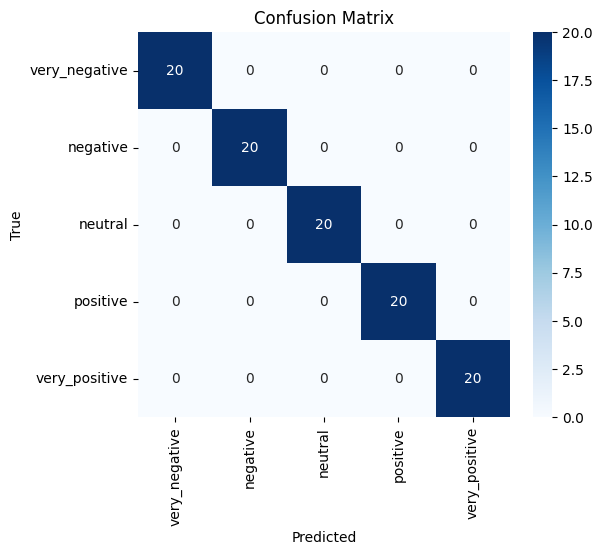

In [7]:
cm = confusion_matrix(true_labels, pred_labels, labels=list(id2label.values()))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(id2label.values()),
            yticklabels=list(id2label.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [8]:
print("Classification Report:")
print(classification_report(true_labels, pred_labels, digits=3))

accuracy = accuracy_score(true_labels, pred_labels)
prec, rec, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")


Classification Report:
               precision    recall  f1-score   support

     negative      1.000     1.000     1.000        20
      neutral      1.000     1.000     1.000        20
     positive      1.000     1.000     1.000        20
very_negative      1.000     1.000     1.000        20
very_positive      1.000     1.000     1.000        20

     accuracy                          1.000       100
    macro avg      1.000     1.000     1.000       100
 weighted avg      1.000     1.000     1.000       100

Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1-score: 1.000
